In [1]:
import sys
import os

# Calculate the absolute path to the project root (one level up) to make src available
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import necessary libraries
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error


# Import functions from your modules.
from src.utils.preprocessing_lr import load_and_preprocess, aggregate_daily, filter_daily, add_lag_features, drop_missing_rows
from src.model.regression import rolling_forecast
from src.visualization.plots_lr import plot_predictions, plot_coefficients, plot_actual_vs_predicted, plot_features, plot_predictions_scientific
from src.model.interpretation import compute_shap_explainer

/opt/homebrew/anaconda3/envs/projectp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
MERGED_DATASET = '../data/penguin/penguins_final_with_era5.csv'

This notebook contains the main code for examining the time series problem of predicting the mean distance to colony for the King George Island colony of Adelie penguins from 2016 to 2017. Using a correlation matrix, relevant features were identified and then experiments were conducted, where - using Linear Regression - the mean distance to colony was predicted using weather covariantes. 

### Correlation matrix - Features and target variable

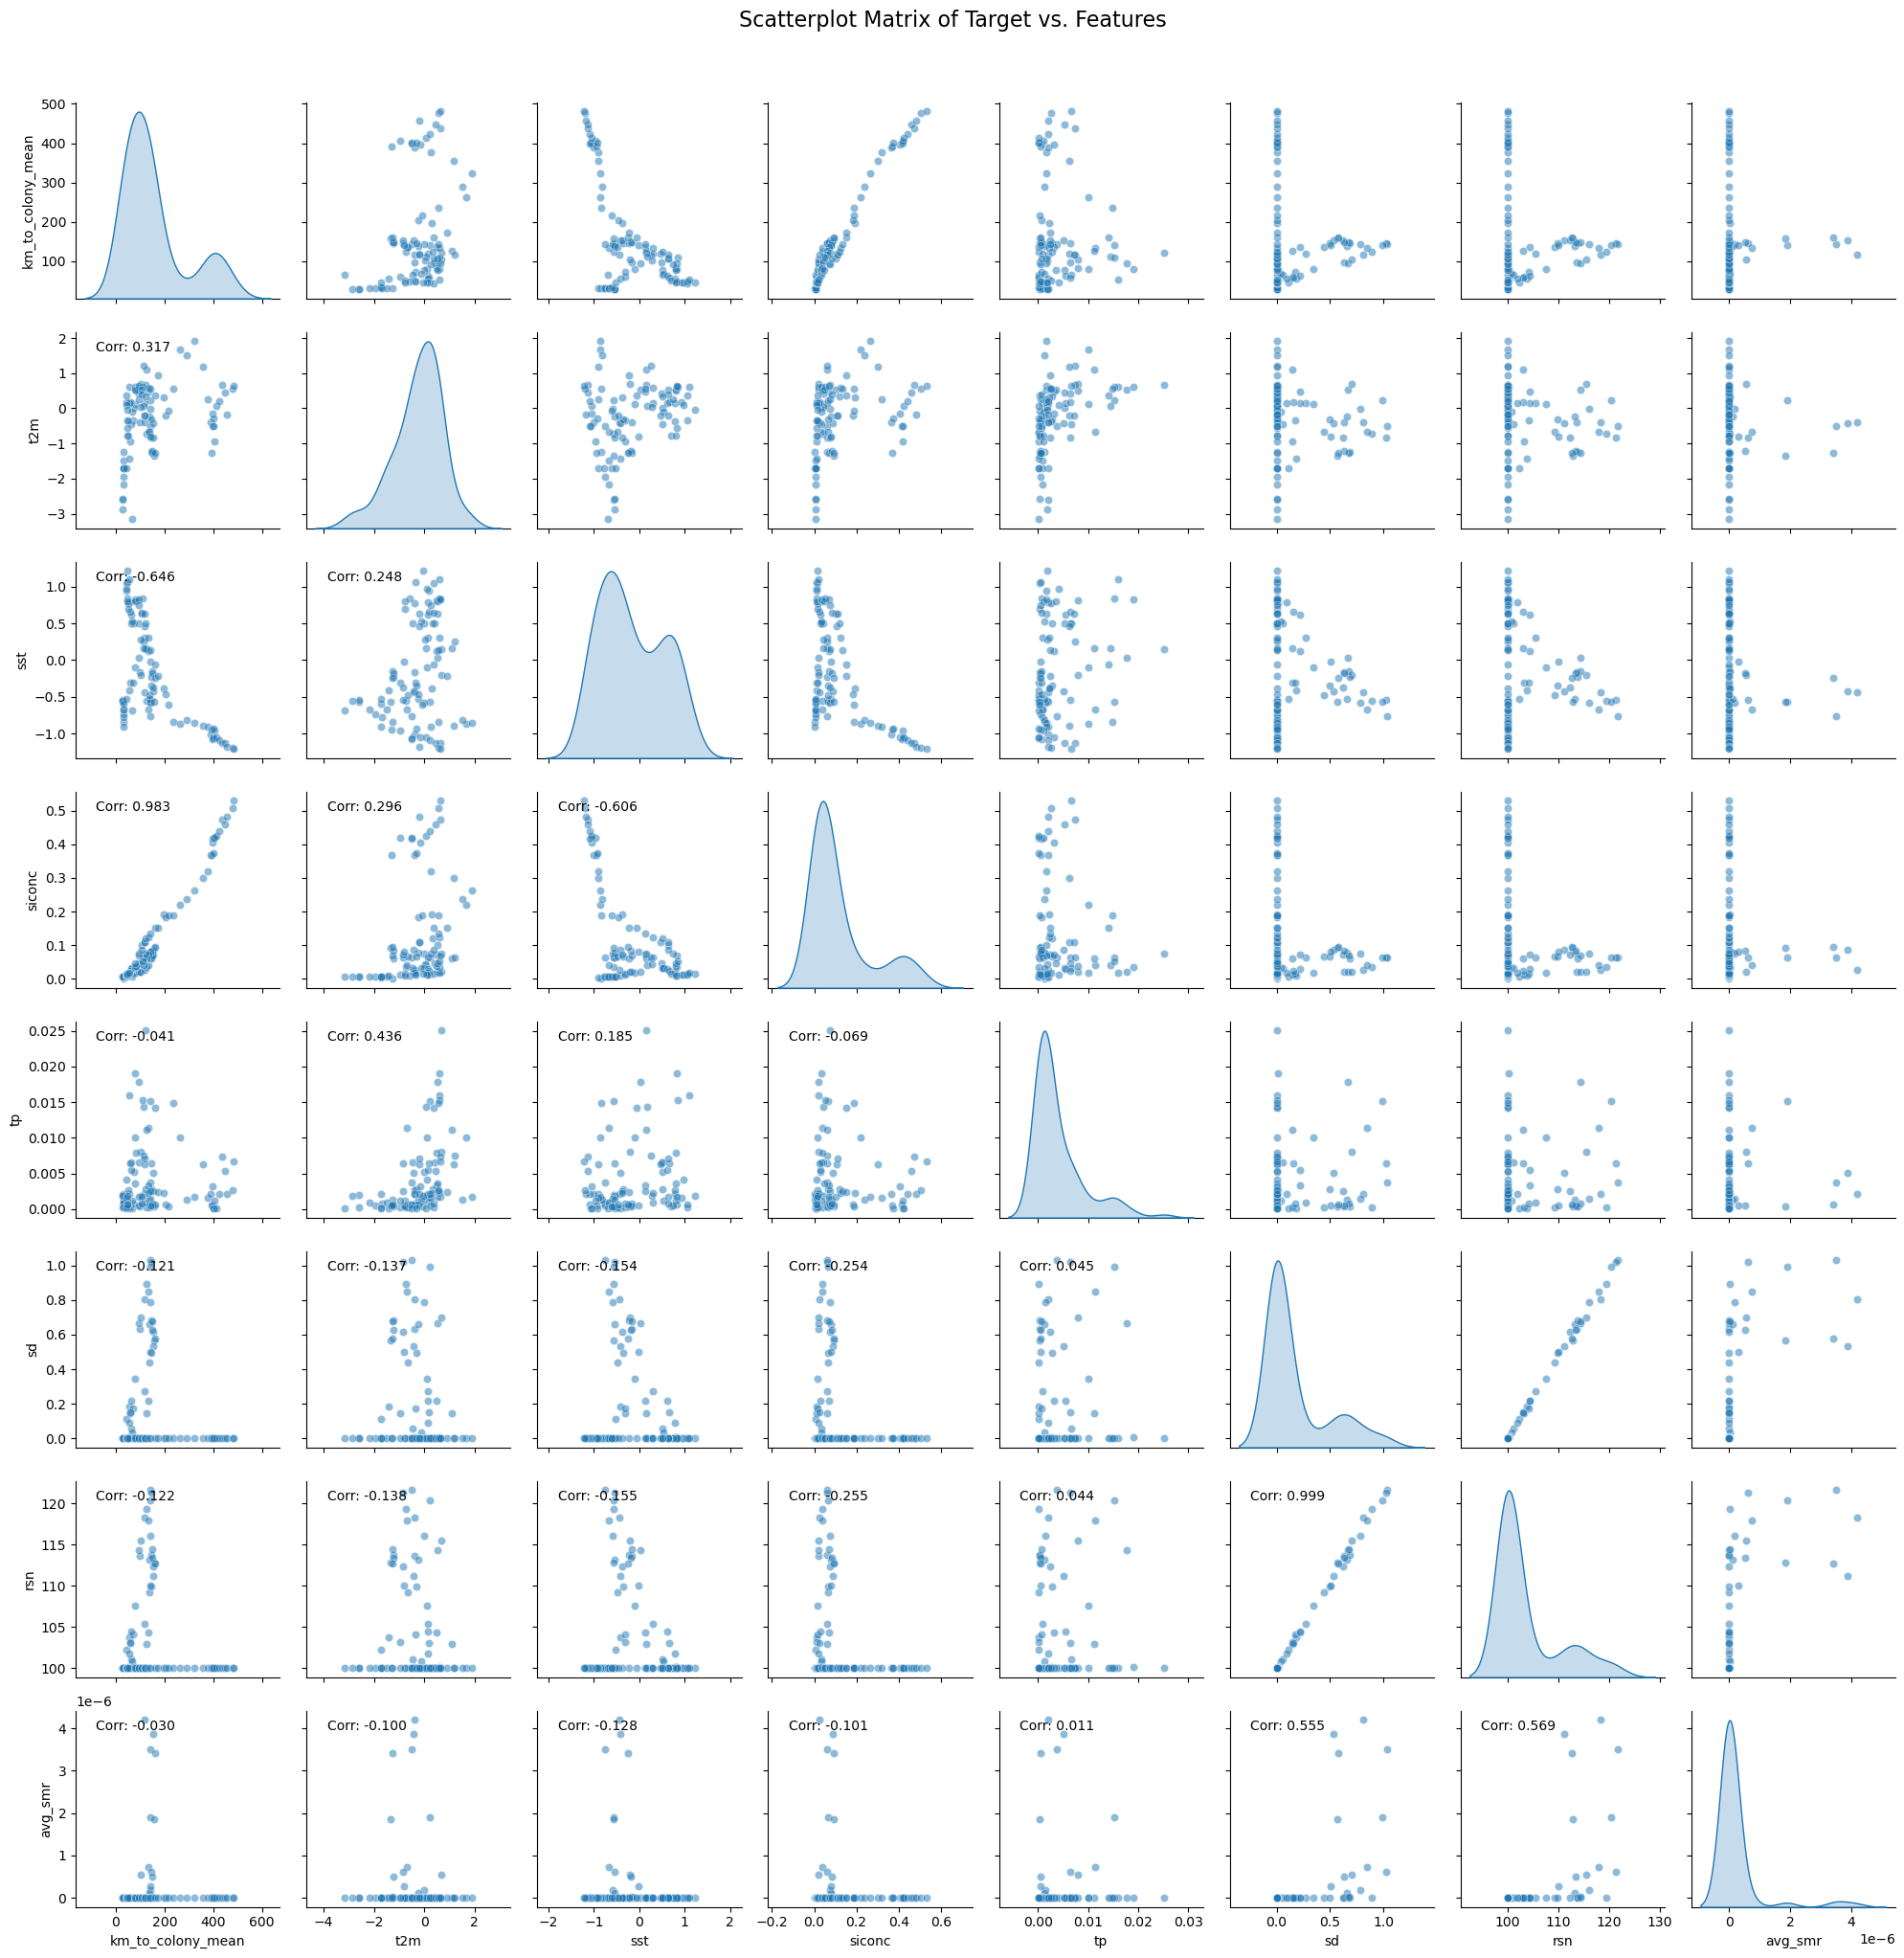

In [3]:
df = load_and_preprocess(MERGED_DATASET)
daily_df = aggregate_daily(df)
daily_df.dropna(inplace=True)

target = 'km_to_colony_mean'
features = ['t2m', 'sst', 'siconc', 'tp', 'sd', 'rsn', 'avg_smr']
scatter_data = daily_df[[target] + features]

# Create a pairplot with correlation coefficients and scatter plots.
def correlation_coeff(x, y, **kwargs):
    corr_r = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.annotate(f'Corr: {corr_r:.3f}', xy=(0.1, 0.9), xycoords=ax.transAxes)

pairplot = sns.pairplot(
    scatter_data,
    diag_kind="kde",  
    plot_kws={"alpha": 0.5}  
)

# Add correlation coefficients to the scatterplots.
pairplot.map_lower(correlation_coeff)

plt.suptitle("Scatterplot Matrix of Target vs. Features", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

### Colony-level prediction - final model using 3 weather covariates, lagged features

After aggregation, 100 daily observations remain.
Overall R²: 0.857, Overall RMSE: 52.380


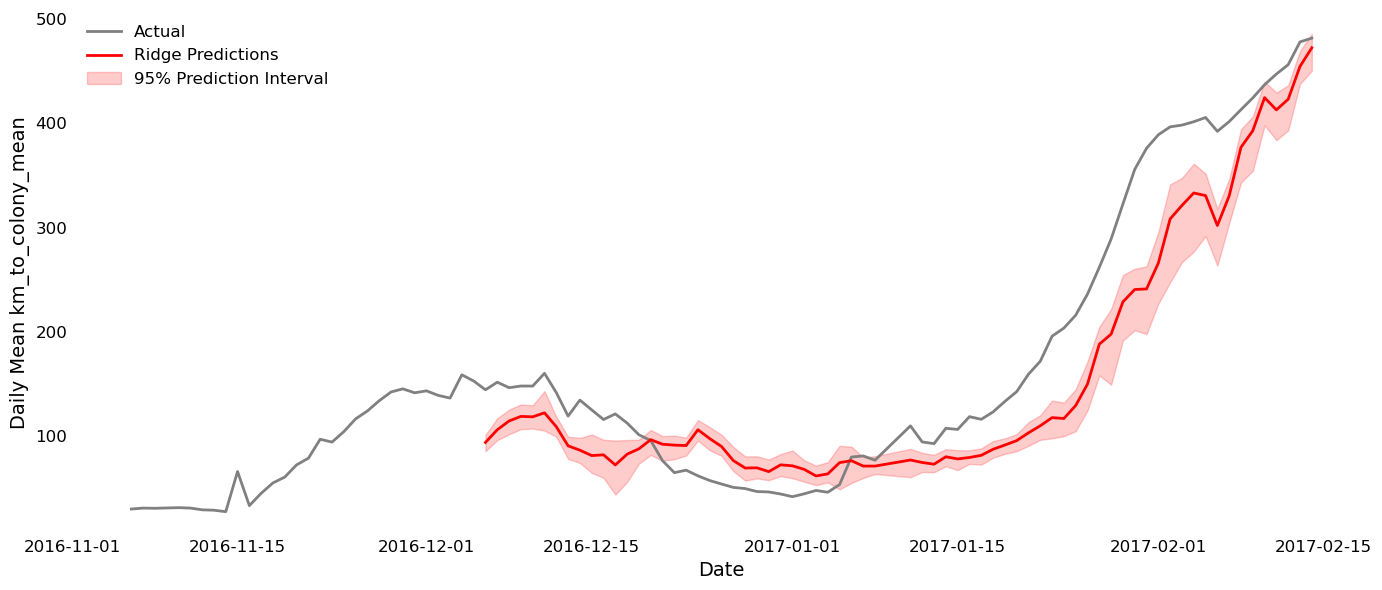

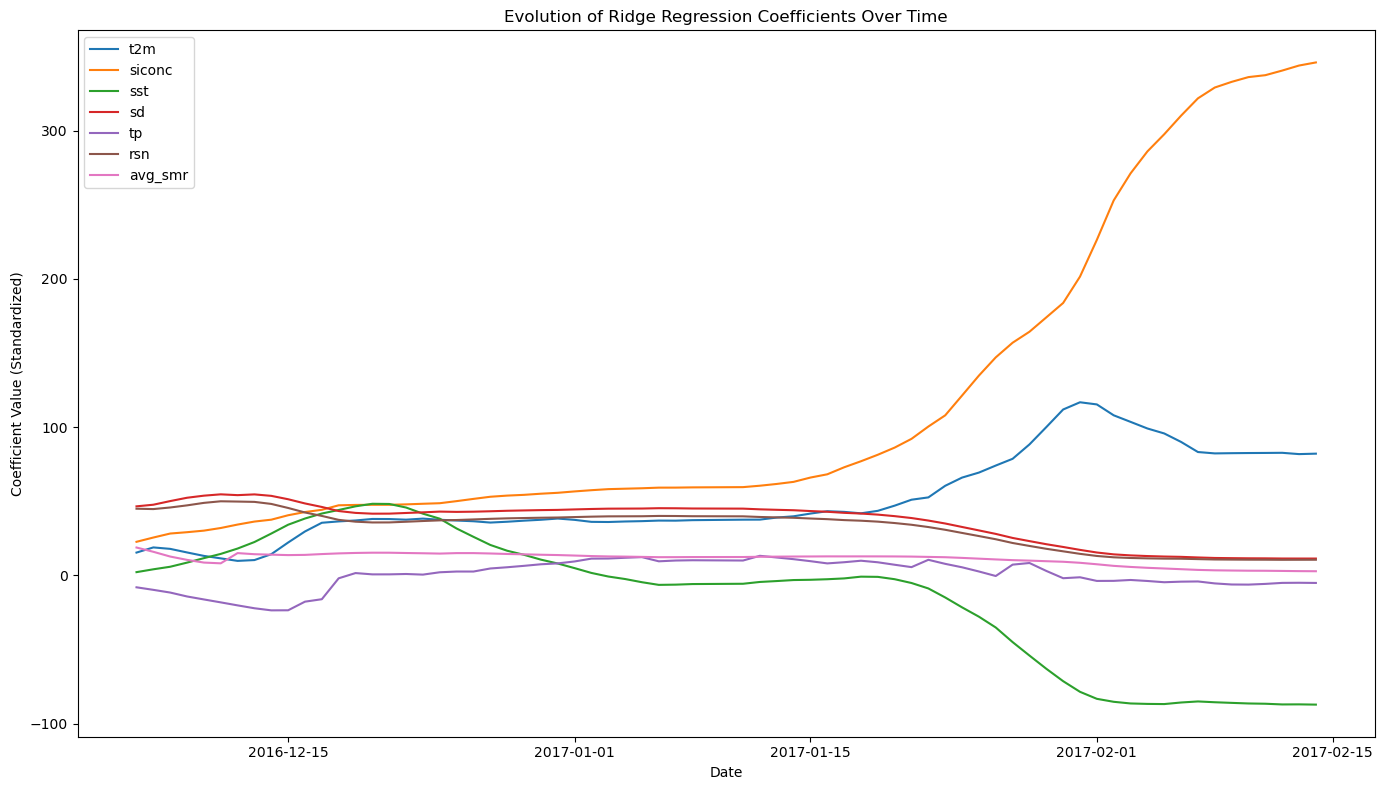

In [10]:
df = load_and_preprocess(MERGED_DATASET)
daily_df = aggregate_daily(df)
daily_df = filter_daily(daily_df, min_records=1)
print(f"After aggregation, {len(daily_df)} daily observations remain.")

# 2. Feature Engineering Without Smoothing.
# We are using raw weather variables: t2m, siconc, and sst.
#lag_features = ['t2m', 'siconc', 'sst']
#daily_df = add_lag_features(daily_df, lag_features, lag=1)
daily_df = drop_missing_rows(daily_df)

# Define predictors and target.
#features = ['t2m', 'siconc', 'sst', 't2m_lag1', 'siconc_lag1', 'sst_lag1']
features = ['t2m', 'siconc', 'sst', 'sd', 'tp', 'rsn', 'avg_smr']
target = 'km_to_colony_mean'
X = daily_df[features]
y = daily_df[target]

# 3. Standardize the Features.
scaler = MinMaxScaler()#StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)

# 4. Rolling Forecast.
initial_training_size = 30
n_bootstrap = 100
results = rolling_forecast(X_scaled, y, initial_training_size=initial_training_size, n_bootstrap=n_bootstrap, alpha=1.0)
print(f"Overall R²: {results['metrics']['r2']:.3f}, Overall RMSE: {results['metrics']['rmse']:.3f}")

# Forecast dates correspond to rows starting at initial_training_size.
forecast_dates = daily_df['date'].values[initial_training_size:]

# 5. Visualization of Predictions with Uncertainty.
plot_predictions_scientific(daily_df, target, forecast_dates,
                 results['predictions'], results['prediction_lower'], results['prediction_upper'])

# 6. Visualization of Coefficient Evolution.
plot_coefficients(results['coefficients'], features, forecast_dates)

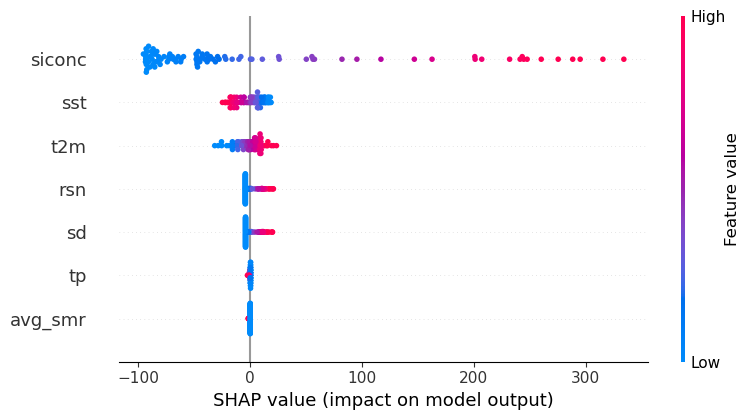

In [6]:
final_model = results['model']
explainer, shap_values = compute_shap_explainer(results['model'], X_scaled)

shap.summary_plot(shap_values, X_scaled)

### Colony-level prediction - model using 3 weather covariates, no lagged features

After aggregation, 100 daily observations remain.
Overall R²: 0.976, Overall RMSE: 21.734


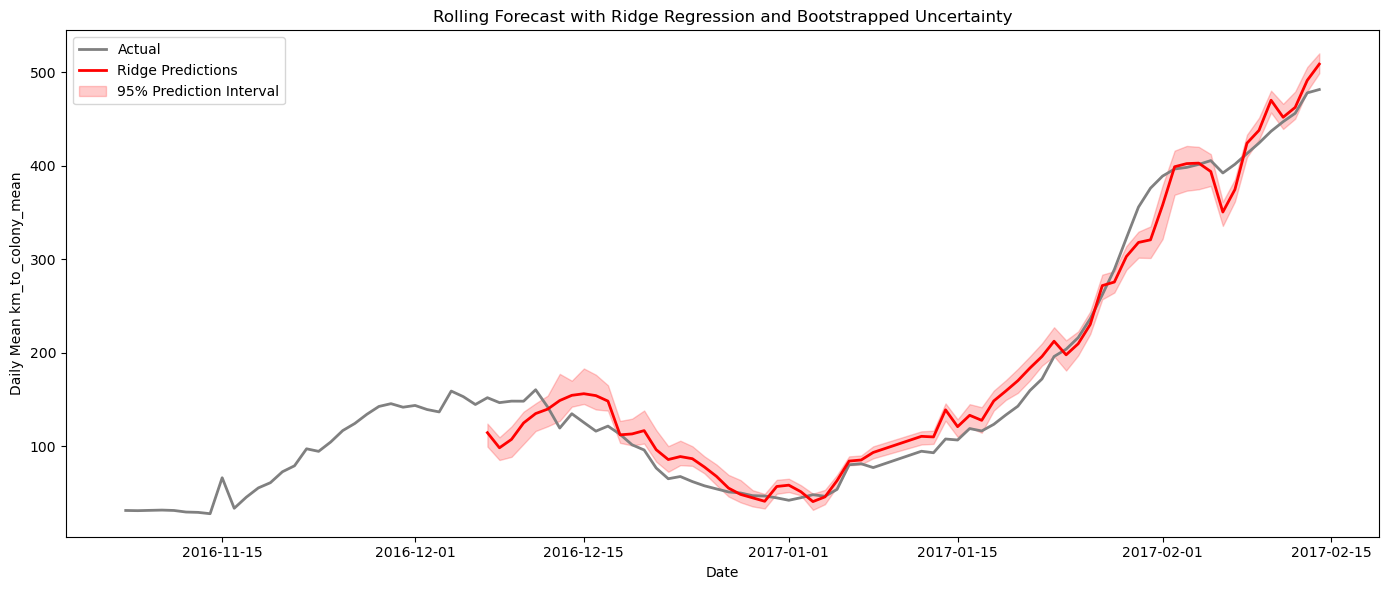

In [6]:
df = load_and_preprocess(MERGED_DATASET)
daily_df = aggregate_daily(df)
daily_df = filter_daily(daily_df, min_records=1)
print(f"After aggregation, {len(daily_df)} daily observations remain.")

# 2. Feature Engineering Without Smoothing.
# We are using raw weather variables: t2m, siconc, and sst.
lag_features = ['t2m', 'siconc', 'sst']
daily_df = add_lag_features(daily_df, lag_features, lag=1)
daily_df = drop_missing_rows(daily_df)

# Define predictors and target.
features = ['t2m', 'siconc', 'sst']
target = 'km_to_colony_mean'
X = daily_df[features]
y = daily_df[target]

# 3. Standardize the Features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)

# 4. Rolling Forecast.
initial_training_size = 30
n_bootstrap = 100
results = rolling_forecast(X_scaled, y, initial_training_size=initial_training_size, n_bootstrap=n_bootstrap, alpha=1.0)
print(f"Overall R²: {results['metrics']['r2']:.3f}, Overall RMSE: {results['metrics']['rmse']:.3f}")

# Forecast dates correspond to rows starting at initial_training_size.
forecast_dates = daily_df['date'].values[initial_training_size:]

# 5. Visualization of Predictions with Uncertainty.
plot_predictions(daily_df, target, forecast_dates,
                 results['predictions'], results['prediction_lower'], results['prediction_upper'])

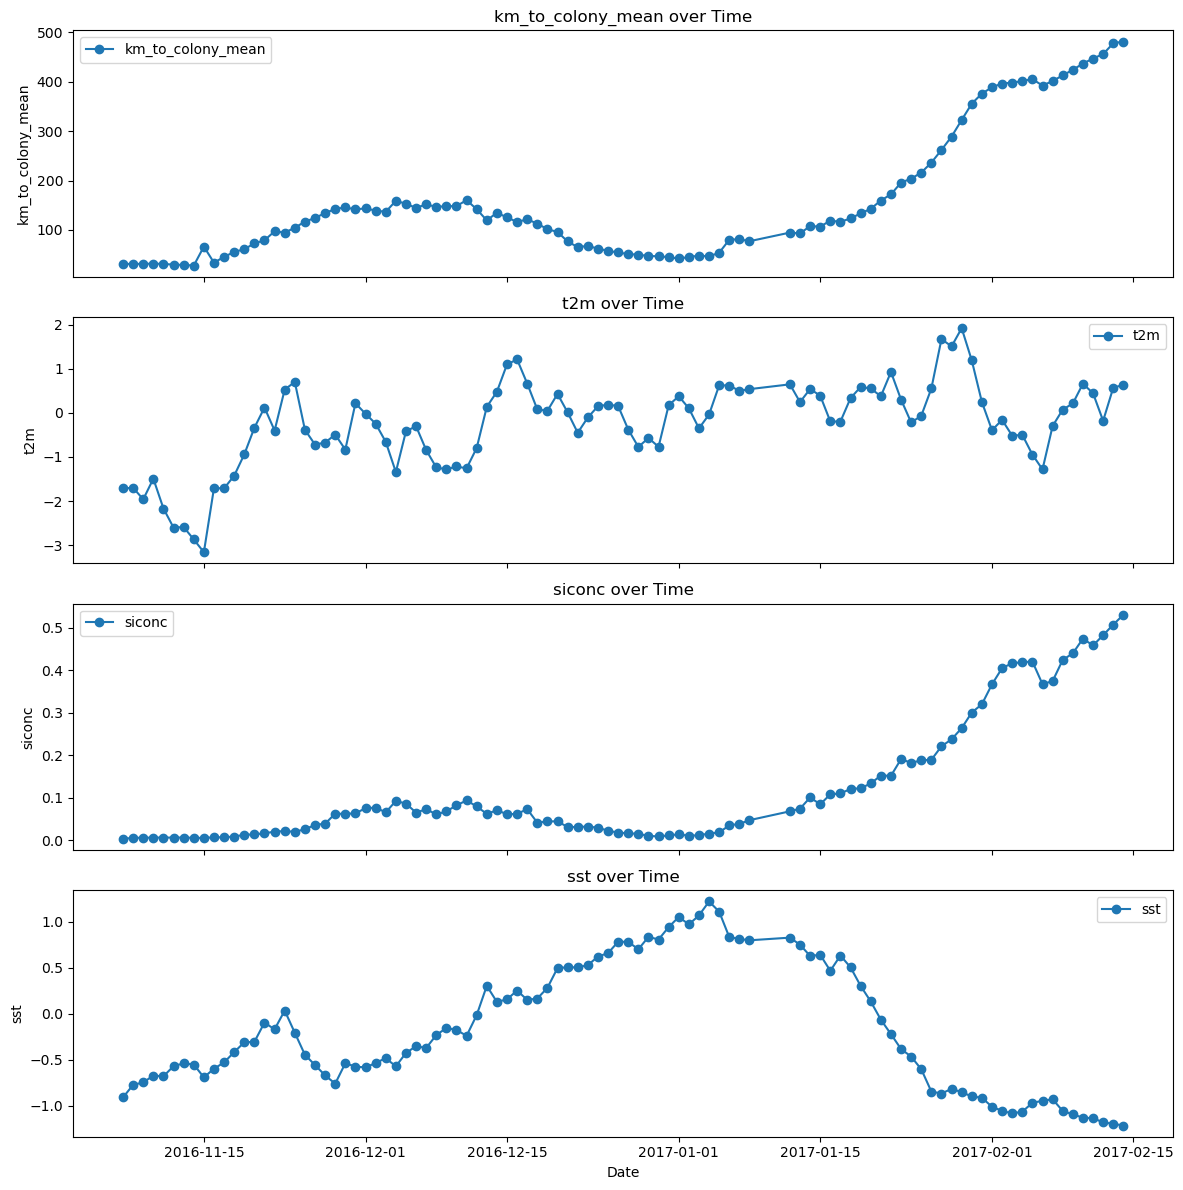

In [9]:
plot_features(daily_df, [target] + features)

### Colony-level prediction - LR using 4 weather covariates and no time component

Linear Regression Performance:
R² Score: 0.725
RMSE: 88.265

Model Coefficients:
  Feature  Coefficient
0     t2m    25.178354
1     sst   -80.915828
2  siconc    73.184444
3      tp    -5.172695


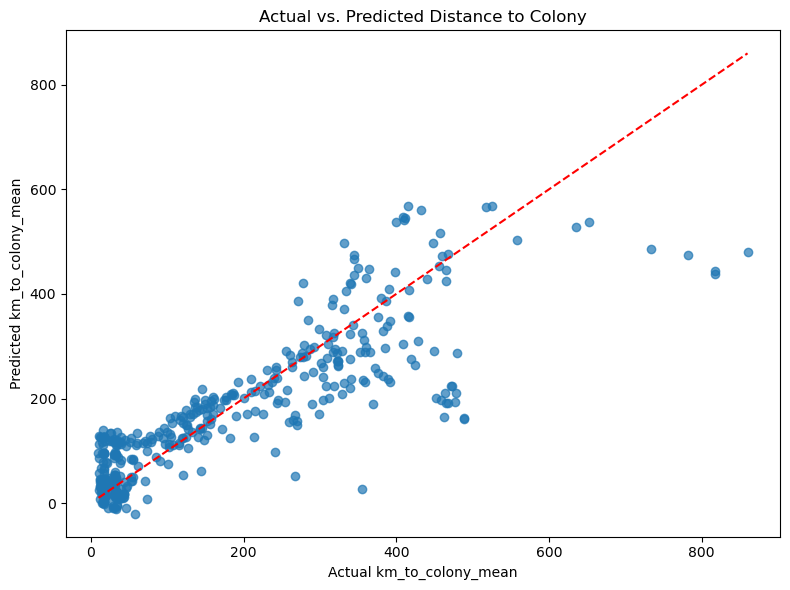

In [ ]:
df = load_and_preprocess(MERGED_DATASET)

# Define Predictors and Target
# We use only t2m, sst, siconc, and tp as features
features = ['t2m', 'sst', 'siconc', 'tp']
target = 'km_to_colony_mean'

# Drop rows with missing values in these columns
df = df.dropna(subset=features + [target])

X = df[features]
y = df[target]

# ----------------------------
# Split the Data
# Use a random train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------
# Standardize the Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# Build and Fit the Linear Regression Model 
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# ----------------------------
# Make Predictions
y_pred = lr_model.predict(X_test_scaled)

# ----------------------------
# Evaluate Performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Linear Regression Performance:")
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Print model coefficients for interpretability.
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_
})
print("\nModel Coefficients:")
print(coefficients)

# ----------------------------
# Plot Actual vs. Predicted Values
plot_actual_vs_predicted(y_test, y_pred)

### Further experiments (unused) - Predicting time folds on colony-level data

After aggregation, 100 daily observations remain.
Ridge Average R² Score (folds 2+ and 3): 0.787
Ridge Average RMSE (folds 2+ and 3): 23.256
\Ridge Coefficients Sorted by Importance:
                  Feature  Ridge Coef  Ridge Importance
4  siconc_smoothed_shift1   43.823402         43.823402
1         siconc_smoothed   38.589445         38.589445
5     sst_smoothed_shift1  -27.730433         27.730433
0            t2m_smoothed   12.163584         12.163584
3     t2m_smoothed_shift1   11.900506         11.900506
2            sst_smoothed   -3.997186          3.997186


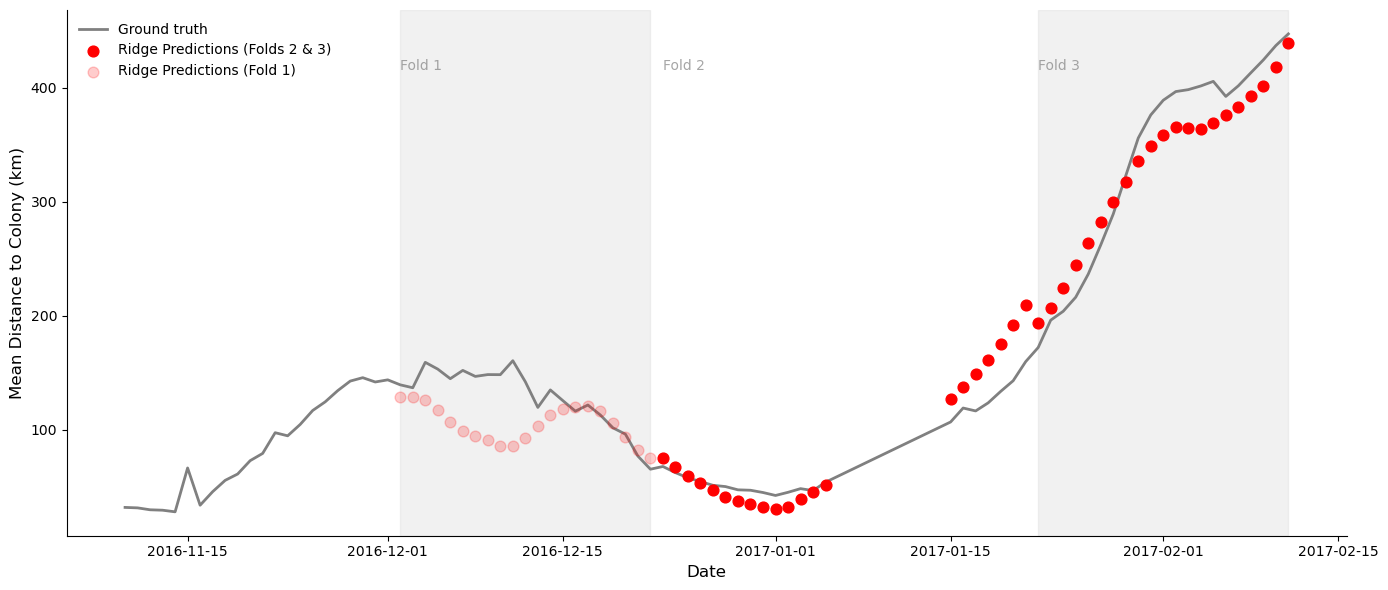

In [12]:
# ----------------------------
# Load and sort data
df = load_and_preprocess(MERGED_DATASET)
daily_df = aggregate_daily(df)
daily_df = filter_daily(daily_df, min_records=1)
print(f"After aggregation, {len(daily_df)} daily observations remain.")

# ----------------------------
# Smooth the selected climate features using a 7-day rolling mean.
smoothing_window = 7
selected_vars = ['t2m', 'siconc', 'sst']
for var in selected_vars:
    daily_df[f'{var}_smoothed'] = daily_df[var].rolling(window=smoothing_window, center=True).mean()

# Create one-day lagged versions of the smoothed features.
for var in selected_vars:
    daily_df[f'{var}_smoothed_shift1'] = daily_df[f'{var}_smoothed'].shift(1)

# ----------------------------
# Drop any remaining missing values (due to smoothing and shifting).
daily_df = daily_df.dropna()

# ----------------------------
# Define feature set and target.
# Use only the smoothed features and their one-day lagged versions.
features = ([f'{var}_smoothed' for var in selected_vars] +
            [f'{var}_smoothed_shift1' for var in selected_vars])
target = 'km_to_colony_mean'

X = daily_df[features]
y = daily_df[target]

# Ensure alignment.
X = X.dropna()
y = y.loc[X.index]
daily_df = daily_df.loc[X.index]

# ----------------------------
# Standardize features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)

# ----------------------------
# Use TimeSeriesSplit to define train/test sets.
tscv = TimeSeriesSplit(n_splits=3)  # Adjust n_splits as needed

ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1)

n_obs = len(X_scaled)
ridge_predictions_all = np.empty(n_obs)
ridge_predictions_all[:] = np.nan

# We'll also record the test indices for fold 1 in order to plot them with low alpha.
fold1_indices = []

# For evaluation metrics, we only use folds 2 and 3.
ridge_r2_scores = []
ridge_rmse_scores = []
test_indices_all = []

fold_num = 1
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train Ridge model.
    ridge_model.fit(X_train, y_train)
    y_pred_ridge = ridge_model.predict(X_test)
    
    # Record predictions for all folds.
    ridge_predictions_all[test_index] = y_pred_ridge
    
    if fold_num == 1:
        # Store indices from fold 1 for later plotting with low opacity.
        fold1_indices.extend(test_index)
    elif fold_num >= 2:
        ridge_r2_scores.append(r2_score(y_test, y_pred_ridge))
        ridge_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
    
    test_indices_all.append(test_index)
    fold_num += 1

print(f"Ridge Average R² Score (folds 2+ and 3): {np.mean(ridge_r2_scores):.3f}")
print(f"Ridge Average RMSE (folds 2+ and 3): {np.mean(ridge_rmse_scores):.3f}")

# ----------------------------
# Print sorted Lasso coefficients for interpretability.
# (Note: Lasso model is still trained but not used for visualization in this example.)
coeff_df = pd.DataFrame({
    'Feature': features,
    'Ridge Coef': ridge_model.coef_ #lasso_model.coef_
})
coeff_df['Ridge Importance'] = coeff_df['Ridge Coef'].abs()
lasso_sorted = coeff_df.sort_values(by='Ridge Importance', ascending=False)
print("\Ridge Coefficients Sorted by Importance:")
print(lasso_sorted[['Feature', 'Ridge Coef', 'Ridge Importance']])

# ----------------------------
# Prepare the date for plotting.
daily_df['date'] = pd.to_datetime(daily_df['date'])

# ----------------------------
# Create masks for fold 1 predictions and folds 2+ predictions.
all_indices = np.arange(n_obs)
fold1_mask = np.zeros(n_obs, dtype=bool)
fold1_mask[fold1_indices] = True
fold2_3_indices = np.where(~fold1_mask)[0]

# ----------------------------
# Plot the actual vs. Ridge predictions.
plt.figure(figsize=(14, 6))

# Plot actual data
plt.plot(daily_df['date'], daily_df[target], label='Ground truth', color='gray', linewidth=2)

# Plot predictions for folds 2 and 3 (full opacity)
plt.scatter(daily_df['date'].iloc[fold2_3_indices], ridge_predictions_all[fold2_3_indices],
            label='Ridge Predictions (Folds 2 & 3)', color='red', s=60, zorder=5)

# Plot predictions for fold 1 (with low alpha)
plt.scatter(daily_df['date'].iloc[fold1_indices], ridge_predictions_all[fold1_indices],
            label='Ridge Predictions (Fold 1)', color='red', alpha=0.2, s=60, zorder=4)

# Mark the boundaries between test folds with shaded regions
for fold_idx, test_idx in enumerate(test_indices_all):
    if len(test_idx) > 0:
        start_date = daily_df.iloc[test_idx[0]]['date']
        end_date = daily_df.iloc[test_idx[-1]]['date']
        # Add a shaded region for the fold
        color = 'lightgray' if fold_idx % 2 == 0 else 'white'  # Alternate colors
        plt.axvspan(start_date, end_date, color=color, alpha=0.3, zorder=1)
        plt.text(start_date, daily_df[target].max() * 0.95, f"Fold {fold_idx+1}",
                 rotation=0, verticalalignment='top', fontsize=10, color='gray', alpha=0.7)

# Axis labels and title
plt.xlabel("Date", fontsize=12)
plt.ylabel("Mean Distance to Colony (km)", fontsize=12)

# Minimalist frame
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ticks and gridlines
#plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=10)

# Legend
plt.legend(frameon=False, fontsize=10)

# Final layout adjustments
plt.tight_layout()
plt.show()


